Here we will utilize our pre-processed and cleaned data set in order to answer our research question: 
### Is lending racially discriminatory in the New York State?

In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression as OLS
from sklearn.linear_model import LogisticRegression as Logit
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
import sys

In [2]:
# Helper function for recognizing NaN values in a DataFrame that are encoded as float('nan')
def isNaN(x):
    return x != x

In [3]:
# Read in csv from pre-processing. We must re-cast types because they were converted to strings upon exporting. 
df = pd.read_csv("encoded_loan_data.csv", sep=',', engine='python', error_bad_lines=False, dtype='unicode')

In [4]:
sorted(df.applicant_race_name_1.unique())

['American Indian or Alaska Native',
 'Asian',
 'Black or African American',
 'Native Hawaiian or Other Pacific Islander',
 'White',
 'nan']

In [5]:
# Define immutable, related set of constant values.
import enum
from functools import total_ordering
@total_ordering
class Race(enum.Enum):
    Native = 'American Indian or Alaska Native'
    Asian = 'Asian'
    Black = 'Black or African American'
    PacificIslander = 'Native Hawaiian or Other Pacific Islander'
    White = 'White'
    nan = 'nan'
    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

Before visualizing this data we must ensure all processed data is numeric. These column types match those discussed in pre-processing.

In [6]:
colToType = {
    "tract_to_msamd_income" : float, 
    "rate_spread" : float,
    "population" : int,
    "minority_population" : bool,
    "number_of_owner_occupied_units" : int, 
    "number_of_1_to_4_family_units" : int, 
    "loan_amount_000s" : float, 
    "hud_median_family_income" : float,
    "applicant_income_000s" : float,
    "sequence_number" : int, 
    "census_tract_number" : float, 
    "applicant_race_name_1": Race,
    "applicant_race_name_2": Race,
    "applicant_race_name_3": Race,
    "applicant_race_name_4": Race,
    "applicant_race_name_5": Race,
}

In [7]:
# Convert aforementioned column types
df_test = df
# Use Pandas drop_duplicates() as evidence that dataset is deduplicated
print("Deduplicated Valid Rows: %d\tFully Deduplicated: %r" 
      % (len(df_test), len(df_test) == len(df_test.drop_duplicates())))
print("Columns: %d" % len(df_test.columns.values))

# Convert types of columns
for colName, colType in colToType.items():
    if colType == int:
        df_test[colName] = df_test[colName].apply(lambda x: x if x != 'nan' else 0).astype(int)
    elif colType == float:
        df_test[colName] = df_test[colName].apply(lambda x: x if x != 'nan' else float('nan')).astype(float)
    elif colType == Race:
        df_test[colName] = df_test[colName].apply(lambda x: Race(x))

Deduplicated Valid Rows: 371894	Fully Deduplicated: True
Columns: 39


In [8]:
numeric_cols = df_test.columns

In [9]:
# Check column types were correctly converted
assert [col in ['int64','float'] for col in [df[y].dtype for y in numeric_cols]]

In [10]:
df.applicant_race_name_1.value_counts()

Race.White              240919
Race.nan                 81469
Race.Black               23676
Race.Asian               23438
Race.Native               1351
Race.PacificIslander      1041
Name: applicant_race_name_1, dtype: int64

Because the samples for Native Americans and Pacific Islanders are so small, we will exclude them for much of the analysis that is testing the effects of race on mortgage approval status.

In [11]:
#Name each income bucket in order to plot data 
df["income_bracket"] = df["income_bracket"].replace('(0, 18]', 1)
df["income_bracket"] = df["income_bracket"].replace('(18, 75]', 2)
df["income_bracket"] = df["income_bracket"].replace('(75, 153]', 3)
df["income_bracket"] = df["income_bracket"].replace('(153, 233]', 4)
df["income_bracket"] = df["income_bracket"].replace('(233, 416]', 5)
df["income_bracket"] = df["income_bracket"].replace('(416, 470]', 6)
df["income_bracket"] = df["income_bracket"].replace('(470, 9999]', 7)
# Applicants with no income reported will be meaningless in our analysis and will be indicated in the -1 column.
df["income_bracket"] = df["income_bracket"].replace('nan', -1)
df["income_bracket"] = df["income_bracket"].astype('float')
df["action_taken_name"] = df["action_taken_name"].astype('float')

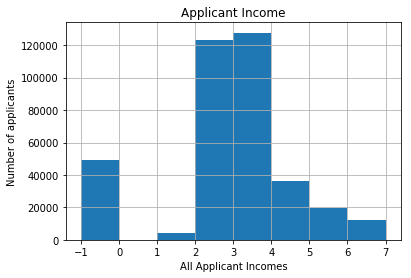

In [12]:
# applicant income histogram
df.income_bracket.hist(bins = range(-1,8))
plt.title('Applicant Income')
plt.xlabel('All Applicant Incomes')
plt.ylabel('Number of applicants')
plt.show()

In [13]:
# Separate data frames to run analyses on gender disaggregated data
df_gender_male = df.copy()
df_gender_female = df.copy()

In [14]:
# Drop all female data
df_gender_male = df_gender_male.drop(df_gender_male[df_gender_male.applicant_sex_name == "Female"].index)

In [15]:
# Drop all male data 
df_gender_female = df_gender_female.drop(df_gender_female[df_gender_female.applicant_sex_name == "Male"].index)

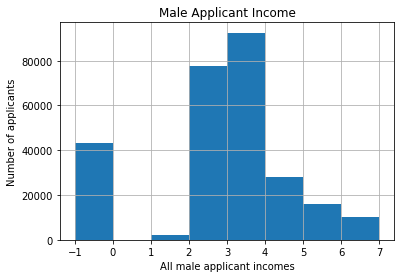

In [16]:
# Applicant income for male histogram
df_gender_male.income_bracket.hist(bins = range(-1,8))
plt.title('Male Applicant Income')
plt.xlabel('All male applicant incomes')
plt.ylabel('Number of applicants')
plt.show()

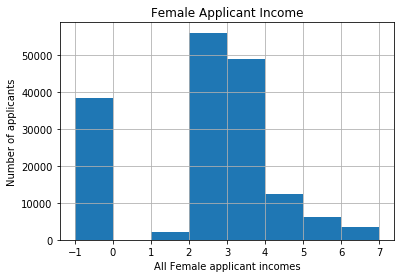

In [17]:
# Applicant income for women histogram
df_gender_female.income_bracket.hist(bins = range(-1,8))
plt.title('Female Applicant Income')
plt.xlabel('All Female applicant incomes')
plt.ylabel('Number of applicants')
plt.show()

#### From these plots we can see that men's income distribution is higher overal the women's which is in line with the general population 

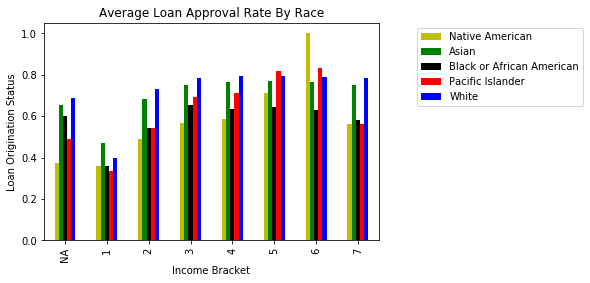

In [18]:
# Graph loan frequency of originated loan/purchased by institution for each income bracket
# disaggregated by race  
fig = plt.figure()
ax = df[(df.applicant_race_name_1 != Race.nan)]\
.groupby(["applicant_race_name_1", "income_bracket"])\
.action_taken_name.mean()\
.reset_index().set_index(["income_bracket", "applicant_race_name_1"])\
.unstack("applicant_race_name_1")\
.rename_axis([None, "applicant_race_name_1"], axis = 1).plot.bar(color = 'ygkrb')

plt.title('Average Loan Approval Rate By Race')
ax.set_xticklabels(["NA"] + list(range(1,8)))
plt.xlabel('Income Bracket')
plt.ylabel('Loan Origination Status')
ax.legend(['Native American', 'Asian', 'Black or African American'
           ,'Pacific Islander','White'], bbox_to_anchor=(1.1, 1.0))
plt.show()

#### The jump in approval for Native Americans and Pacific Islanders relative to other races around income bracket 6 is an artifact because there are only 5 Native Americans in this income bracket and 6 Pacific Islanders. 

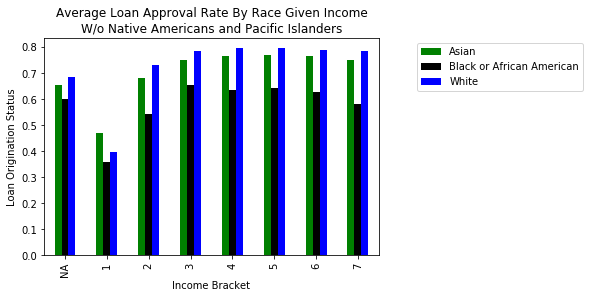

In [19]:
# Graph loan frequency of originated loan/purchased by institution for each income bracket
# disaggregated by race only for Asian, Black, and White
fig = plt.figure()
ax = df[~(df.applicant_race_name_1.isin([Race.nan, Race.Native, Race.PacificIslander]))]\
.groupby(["applicant_race_name_1", "income_bracket"])\
.action_taken_name.mean()\
.reset_index().set_index(["income_bracket", "applicant_race_name_1"])\
.unstack("applicant_race_name_1")\
.rename_axis([None, "applicant_race_name_1"], axis = 1).plot.bar(color = 'gkb')

plt.title('Average Loan Approval Rate By Race Given Income\nW/o Native Americans and Pacific Islanders')
ax.set_xticklabels(["NA"] + list(range(1,8)))
plt.xlabel('Income Bracket')
plt.ylabel('Loan Origination Status')
ax.legend(['Asian', 'Black or African American', 'White'], bbox_to_anchor=(1.1, 1.0))
plt.show()

In [20]:
# Calculate diff between asian and white, black and white, frequencies of originated loans/purchased by institution 
whiteMeans = df[(df.applicant_race_name_1 == Race.White) & (df.income_bracket > 0)]\
.groupby(["applicant_race_name_1", "income_bracket"])\
.action_taken_name.mean().reset_index().set_index("income_bracket").drop("applicant_race_name_1", axis = 1)

asianMeans = df[(df.applicant_race_name_1 == Race.Asian) & (df.income_bracket > 0)]\
.groupby(["applicant_race_name_1", "income_bracket"])\
.action_taken_name.mean().reset_index().set_index("income_bracket").drop("applicant_race_name_1", axis = 1)

blackMeans = df[(df.applicant_race_name_1 == Race.Black) & (df.income_bracket > 0)]\
.groupby(["applicant_race_name_1", "income_bracket"])\
.action_taken_name.mean().reset_index().set_index("income_bracket").drop("applicant_race_name_1", axis = 1)

asianDiffRelWhites = (asianMeans - whiteMeans).mean()
blackDiffRelWhites = (blackMeans - whiteMeans).mean()

print("After controlling for income, asians were %0.2f%% less likely to get a loan approved relative to whites." % 
      (asianDiffRelWhites * 100))
print("After controlling for income, blacks were %0.2f%% less likely to get a loan approved relative to whites." %
      (blackDiffRelWhites * 100))

After controlling for income, asians were -1.83% less likely to get a loan approved relative to whites.
After controlling for income, blacks were -14.82% less likely to get a loan approved relative to whites.


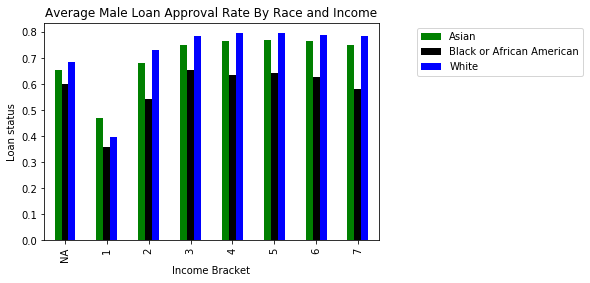

In [21]:
# Same graph but exclusively for primary male applicants
fig = plt.figure()
ax = df[df.applicant_race_name_1.isin([Race.Asian, Race.Black, Race.White])]\
.groupby(["applicant_race_name_1", "income_bracket"]).action_taken_name\
.mean()\
.reset_index().set_index(["income_bracket", "applicant_race_name_1"])\
.unstack("applicant_race_name_1")\
.plot.bar(color = 'gkb')

ax.legend(["Asian", "Black or African American", "White"], bbox_to_anchor=(1.1, 1.0))
ax.set_xticklabels(["NA"] + list(range(1,8)))
plt.title('Average Male Loan Approval Rate By Race and Income')
plt.xlabel('Income Bracket')
plt.ylabel('Loan status')
plt.show()

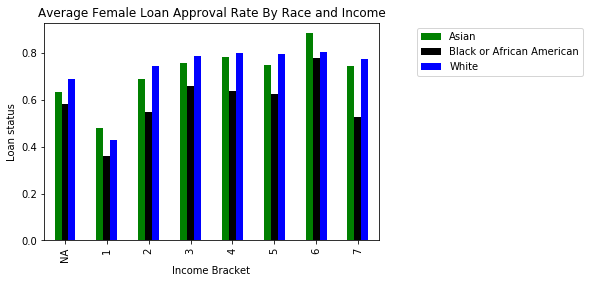

In [22]:
# Same graph but exclusively for primary female applicants
fig = plt.figure()
ax = df_gender_female[df_gender_female.applicant_race_name_1.isin([Race.Asian, Race.Black, Race.White])]\
.groupby(["applicant_race_name_1", "income_bracket"]).action_taken_name\
.mean()\
.reset_index().set_index(["income_bracket", "applicant_race_name_1"])\
.unstack("applicant_race_name_1")\
.plot.bar(color = 'gkb')

plt.title('Average Female Loan Approval Rate By Race and Income')
ax.set_xticklabels(["NA"] + list(range(1,8)))
plt.xlabel('Income Bracket')
plt.ylabel('Loan status')
ax.legend(['Asian', 'Black or African American','White'], bbox_to_anchor=(1.1, 1.0))
plt.show()

Looking at the mean number of application results for each race, we see for any income bracket, aside from one of the higher income brackets, there is a consistent discrepancy between loan status and race. Black or African American applicants were denied loan applications more frequently than white applicants. The amount by which the number of applicants with originated loans differ, is inconsistent between different races and across different income brackets.

In [23]:
#Loan status proportions and counts by applicant race and income bracket.
p_afram = df[df.applicant_race_name_1== Race.Black].groupby('income_bracket').action_taken_name.mean()
n_afram = df[df.applicant_race_name_1== Race.Black].groupby('income_bracket').action_taken_name.count()

p_white = df[df.applicant_race_name_1== Race.White].groupby('income_bracket').action_taken_name.mean()
n_white = df[df.applicant_race_name_1== Race.White].groupby('income_bracket').action_taken_name.count()

p_asian = df[df.applicant_race_name_1== Race.Asian].groupby('income_bracket').action_taken_name.mean()
n_asian = df[df.applicant_race_name_1== Race.Asian].groupby('income_bracket').action_taken_name.count()

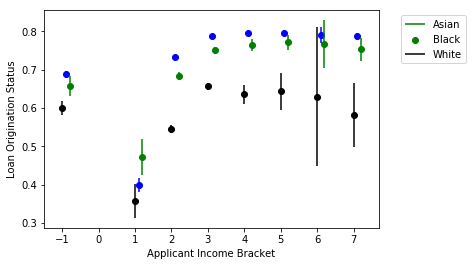

In [24]:
#Plot the proportions with 1-SD error bars
fig = plt.figure()
ax = plt.subplot(111)
x = np.array([-1] + list(range(1,8)))

sd_asian = 1.96*np.sqrt(p_asian*(1-p_asian)/n_asian)
plt.vlines(x+.2, p_asian+sd_asian, p_asian-sd_asian, color='green')
a1 = plt.scatter(x + 0.2, p_asian, color='green', label="Asian")

sd_afram = 1.96*np.sqrt(p_afram*(1-p_afram)/n_afram)
plt.vlines(x, p_afram+sd_afram, p_afram-sd_afram, color='black')
b1 = plt.scatter(x, p_afram, color='black', label="Black")

sd_white = 1.96*np.sqrt(p_white*(1-p_white)/n_white)
plt.vlines(x+.1, p_white+sd_white, p_white-sd_white, color='blue')
c1 = plt.scatter(x + 0.1, p_white, color='blue', label="White")

# a2 = plt.plot(x[1:] + 0.2, p_asian[1:], color = 'green')
# b2 = plt.plot(x[1:], p_afram[1:], color='black')
# c2 = plt.plot(x[1:] + 0.1, p_white[1:], color='blue')

plt.ylabel('Loan Origination Status')
plt.xlabel('Applicant Income Bracket')
plt.xticks(range(-1,8))
ax.legend(["Asian", "Black", "White"], bbox_to_anchor=(1.05, 1.0))
plt.show()

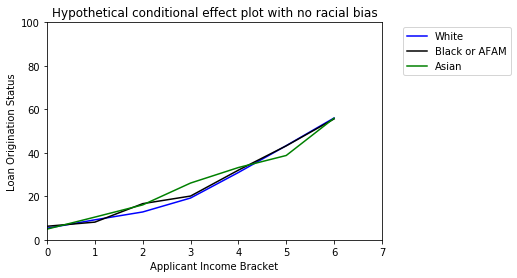

In [25]:
# Abe Gong's hypothetical no bias plot
fig = plt.figure()
ax = plt.subplot(111)
X = np.arange(-1,7)
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='blue')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='black')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='green')
plt.title("Hypothetical conditional effect plot with no racial bias")
plt.ylabel('Loan Origination Status')
plt.xlabel('Applicant Income Bracket')
plt.xlim(0,max(X) + 1)
plt.ylim(0,100)
ax.legend(["White", "Black or AFAM", "Asian"], bbox_to_anchor=(1.4, 1.0))
plt.show()

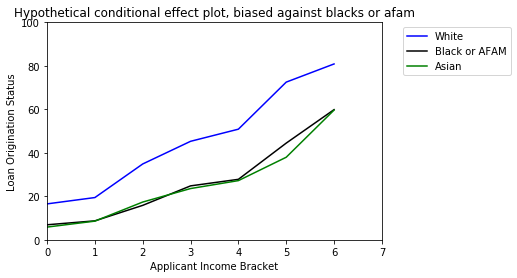

In [26]:
# Abe Gong's hypothetical biased plot
fig = plt.figure()
ax = plt.subplot(111)
X = np.arange(-1,7)
plt.plot(X, 100/(1+np.exp(.5*(3-X+np.random.uniform(size=8)))), color='blue')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='black')
plt.plot(X, 100/(1+np.exp(.5*(5-X+np.random.uniform(size=8)))), color='green')
plt.title("Hypothetical conditional effect plot, biased against blacks or afam")
plt.ylabel('Loan Origination Status')
plt.xlabel('Applicant Income Bracket')
plt.xlim(0,max(X) + 1)
plt.ylim(0,100)
ax.legend(["White", "Black or AFAM", "Asian"], bbox_to_anchor=(1.4, 1.0))
plt.show()

If there were a systematic bias against nonwhite applicants, we would expect the plots below to look similar to this. They don't because it seems that the bias is more subtle than across the board discrimination. 

### Using this data to automate loan approval

Now, using the 2015 New York State loan data, we'll train a logistic regression classifier to determine whether this apparent bias against African Americans (when we control solely for income) would still appear in a classifier that ideally would control for additional factors. In training this classifier, we'll exclude characteristics that are explicitly racially focused (race of applicant name, fraction of neighborhood that is a minority population, census tract, etc). 

In [27]:
np.array(sorted(df_test.columns))

array(['action_taken_name', 'agency_abbr', 'agency_name',
       'applicant_ethnicity_name', 'applicant_income_000s',
       'applicant_race_name_1', 'applicant_race_name_2',
       'applicant_race_name_3', 'applicant_race_name_4',
       'applicant_race_name_5', 'applicant_sex_name',
       'census_tract_number', 'co_applicant_ethnicity_name',
       'co_applicant_race_name_1', 'co_applicant_sex_name', 'county_name',
       'denial_reason_name_1', 'denial_reason_name_2',
       'denial_reason_name_3', 'edit_status_name', 'hoepa_status_name',
       'hud_median_family_income', 'income_bracket', 'lien_status_name',
       'loan_amount_000s', 'loan_purpose_name', 'loan_type_name',
       'minority_population', 'msamd_name',
       'number_of_1_to_4_family_units', 'number_of_owner_occupied_units',
       'owner_occupancy_name', 'population', 'preapproval_name',
       'purchaser_type_name', 'rate_spread', 'respondent_id',
       'sequence_number', 'tract_to_msamd_income'], dtype='<U30')

Model: 
action_taken_name ~ applicant_income_000s + hud_median_family_income +  loan_amount_000s + number_of_1_to_4_family_units + number_of_owner_occupied_units + population + I\[agency_abbr\] + I\[income_bracket\] + I\[lien_status_name\] + I\[loan_purpose_name\] + I\[loan_type_name\] + I\[owner_occupancy_name\]

Excluded variables: 

* agency_name: redundant with agency_abbr
* (co\_)applicant\_\[ethnicity | race\]\_name\_\[1|2|3|4|5\]: we're excluding explicitly racial characteristics from the regression
* application_date_indicator: unlikely the time at which one applies should influence one's outcome
* as_of_year: 2015 for all data points
* census_tract_number: people's home/address is often highly correlated with their race so we will exclude this from the analysis.
* county_name: census_tract is more specific
* denial\_reason\_\[1|2|3\]: if this is not nan then the applicant was rejected and so it predicts the outcome almost always
* hoepa_status_name: in all but 56 out of ~372k records this is "Not a HOEPA loan". Excluded b/c uninformative
* minority_population: too much of a racial proxy
* msamd_name: captured by the census tracts
* preapproval_name: almost always nan
* property_type_name: always "One-to-four family dwelling"
* rate_spread: almost always nan and would be important but not populated until 2018 (unreleased) HMDA data set.
* respondent_id: irrelevant. This is the lender's unique id
* sequence_number: irrelevant. This is the loan id number
* state_abbr: always "NY"
* state_name: always "New York"
* tract_to_msamd_income: if we include hud_median_family_income, tract_to_msamd_income is redundant because it says how many times greater a tract's income is relative to the median of the metro area, while hud captures the median income of the area. So they're highly correlated

A variable that is denoted  I\[$\cdot$\] is a discrete variable and so each of the possible values the categories could take on will be represented with an indicator variable.  All of the continuous variables are Z-Scored (demeaned and standardized) so that the result and coefficients of the logistic regression are interpretable, and no particular feature gets too much weight in the logistic regression or causes numerical problems because of the difference in the size of the features. 

In [28]:
# One hot encoding converts categorical variables into a form that is better for ML. 
# Specific value types are unique for each category.
def oneHotFromCategory(rowValue, uniqueCategoryValues):
    return np.array(list(map(lambda x: int(x == rowValue), uniqueCategoryValues)))

In [29]:
continuousVars = ["applicant_income_000s", "hud_median_family_income", "loan_amount_000s",
               "number_of_1_to_4_family_units", "number_of_owner_occupied_units", "population"]

discreteVars = ["agency_abbr", "income_bracket", "lien_status_name", "loan_purpose_name", 
                "loan_type_name", "owner_occupancy_name", "purchaser_type_name"]

### Prepare data for Logistic Regression
Z-Scoring all the continuous variables and converting all of the discrete label data points into indicators takes time so we cache the transformed data as a pickled file.  If we have the pickled file, read that in. Otherwise generate a new version.  This takes a few minutes on our laptops. 

In [30]:
logisticFilename = 'logisticData_with_Dummies_2.pickle'
logisticDataExists = os.path.isfile(logisticFilename)
if logisticDataExists:
    with open(logisticFilename, 'rb') as f:
        logisticData = pickle.load(f)
else:
    logisticData = df_test[df_test.applicant_race_name_1.isin([Race.Asian, Race.Black, Race.White])]\
                   [["action_taken_name"] + continuousVars + discreteVars].copy()
    n0 = len(logisticData)
    logisticData = logisticData.dropna()
    for var in set(discreteVars) - set(['income_bracket']):
        logisticData = logisticData[logisticData[var] != 'nan']
    n1 = len(logisticData)
    print("Start: %d\tComplete: %d\tDropped: %d (%.2f%%)" % (n0, n1, n0 - n1, 100 * (n0 - n1) / float(n0)))

    # # Z-Score Continuous Variables
    for var in continuousVars:
        logisticData[[var]] = (logisticData[[var]] - logisticData[[var]].mean()) /  logisticData[[var]].std()

    # Add Dummy Variables for Discrete Variables
    addDummiesFor = sorted(list(discreteVars))
    for var in addDummiesFor:
        sys.stdout.write("Starting: "); sys.stdout.write(var); sys.stdout.write("\t")
        u = sorted(logisticData[var].unique())
        r = logisticData.apply(lambda x: oneHotFromCategory(x[var], u), axis = 1)
        out = np.array([i for i in r.values])
        logisticData = logisticData.join(pd.DataFrame(out, columns = u, index = logisticData.index))
        sys.stdout.write("Finished: "); sys.stdout.write(var); sys.stdout.write("\n")

    with open(logisticFilename, 'wb') as f:
        pickle.dump(logisticData, f, pickle.HIGHEST_PROTOCOL)

In [31]:
# Shorten the names of the columns
logisticDataColNames = {
    1.0 : "IncomeLevel_1",
    2.0 : "IncomeLevel_2",
    3.0 : "IncomeLevel_3",
    4.0 : "IncomeLevel_4",
    5.0 : "IncomeLevel_5",
    6.0 : "IncomeLevel_6",
    7.0 : "IncomeLevel_7",
    "Not secured by a lien" : "LienUnsecured",
    "Secured by a first lien" : "FirstLienSecured",
    "Secured by a subordinate lien" : "SubordinateLienSecured",
    "Home improvement" : "HomeImprovement",
    "Home purchase" : "HomePurchase",
    "FHA-insured" : "FHA_insured",
    "FSA/RHS-guaranteed" : "FSA_RHS_guaranteed",
    'VA-guaranteed' : 'VA_guaranteed',
    'Not owner-occupied as a principal dwelling' : "NotOwnerOccupied",
    'Owner-occupied as a principal dwelling' : "OwnerOccupied",
    'Affiliate institution' : "AffiliateInstitution",
    'Commercial bank, savings bank or savings association' : "CommercialBank",
    'Fannie Mae (FNMA)' : "FannieMae",
    'Farmer Mac (FAMC)' : "FarmerMac",
    'Freddie Mac (FHLMC)' : "FreddieMac",
    'Ginnie Mae (GNMA)' : "GinnieMae",
    'Life insurance company, credit union, mortgage bank, or finance company' : "LifeInsurance",
    'Loan was not originated or was not sold in calendar year covered by register' : "WrongYear",
    'Other type of purchaser' : "OtherPurchaser",
    'Private securitization' : "PrivateSecuritization"
}
logisticData = logisticData.rename(logisticDataColNames, axis = 1)

### Train the logistic regression model with the above features

In [32]:
np.random.seed(4321) # use the same seed to ensure we get the same training data every time
trainData, testData = train_test_split(logisticData, test_size=0.2)

X_train = trainData.drop(discreteVars + ["action_taken_name"] , axis = 1)
y_train_binary = trainData.action_taken_name

X_test = testData.drop(discreteVars + ["action_taken_name"] , axis = 1)
y_test_binary = testData.action_taken_name

In [33]:
binary_model = Logit(solver = "lbfgs", max_iter = 1000)
binary_model.fit(X_train.values, y_train_binary.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
logit_predictions = binary_model.predict(X_test.values)

accuracy = sum(list(map(lambda x: int(x), (logit_predictions == y_test_binary)))) / len(X_test)
print("Accuracy rate of trained model: %0.2f%%" % (accuracy * 100))

Accuracy rate of trained model: 85.67%


#### Just as a quick sanity check to make sure the model gives reasonable results, the print out below shows that as a respondent moves into higher income brackets, the better the applicant's chances become at being approved for a loan, all else equal.

In [35]:
modelValues = pd.DataFrame(np.array([X_test.columns.values, binary_model.coef_[0]]).T, 
             columns = ["parameterName", "coef"])
modelValues[modelValues.parameterName.isin(["IncomeLevel_%d" % i for i in range(1,8)])]

,parameterName,coef
12,IncomeLevel_1,-1.66355
13,IncomeLevel_2,-0.655781
14,IncomeLevel_3,-0.28161
15,IncomeLevel_4,0.148874
16,IncomeLevel_5,0.543851
17,IncomeLevel_6,0.819632
18,IncomeLevel_7,0.906755


#### To see if our classifier is biased against certain races, we will group the predictions for each racial group into 10 groups [0,0.1], ... [0.9,1.0] and then see if for each group, the true probability of receiving a loan varied by race. 

In [36]:
# create a dataframe that computes the true approval rating for each decile 
def createRaceAndProbData(df_test, binary_model, X_test):
    originalWithProbs = df_test\
    .join(pd.DataFrame(binary_model.predict_proba(X_test)[:,1], 
                       columns = ["probOfAcceptance"], index = X_test.index))
    originalWithProbs = originalWithProbs[~isNaN(originalWithProbs.probOfAcceptance)]

    # Group approval probabilities by race and then by decile
    raceAndProbData = originalWithProbs[originalWithProbs.applicant_race_name_1.isin(
                      [Race.Asian, Race.Black, Race.White])]\
                      [["applicant_race_name_1", "probOfAcceptance", "action_taken_name"]]\
                      .sort_values(["probOfAcceptance"], ascending = False)

    raceAndProbData["probBucket"] = raceAndProbData.probOfAcceptance.apply(lambda x: round((x + 0.0499999999) * 10))
    means = raceAndProbData\
    .groupby(["applicant_race_name_1", "probBucket"])\
    .action_taken_name\
    .mean()\
    .reset_index(name = "meanAcceptance")\
    .set_index(["applicant_race_name_1", "probBucket"])

    raceAndProbData = raceAndProbData.set_index(["applicant_race_name_1", "probBucket"])
    raceAndProbData["meanAcceptance"] = means.meanAcceptance
    raceAndProbData = raceAndProbData.reset_index()

    raceAndProbData["predictedOutcome"] = raceAndProbData.probOfAcceptance.apply(lambda x: int(x >= 0.5))

    del(means)
    return raceAndProbData 

In [37]:
# Plot the actual approval rates by racial group against the rates that our model predicts
def plotTrueVsPredictedApprovalByRace(raceAndProbData, raceIncluded = False):
    fig = plt.figure()
    ax = plt.subplot(111)

    asianData = raceAndProbData[raceAndProbData.applicant_race_name_1 == Race.Asian][["probBucket", "meanAcceptance"]]\
                .drop_duplicates().reset_index()
    blackData = raceAndProbData[raceAndProbData.applicant_race_name_1 == Race.Black][["probBucket", "meanAcceptance"]]\
                .drop_duplicates().reset_index()
    whiteData = raceAndProbData[raceAndProbData.applicant_race_name_1 == Race.White][["probBucket", "meanAcceptance"]]\
                .drop_duplicates().reset_index()

    plt.scatter(asianData.probBucket, asianData.meanAcceptance, label = "Asian", color = 'g')
    plt.scatter(blackData.probBucket, blackData.meanAcceptance, label = "Black", color = 'k')
    plt.scatter(whiteData.probBucket, whiteData.meanAcceptance, label = "White", color = 'b')

    plt.xlabel("Predicted Probability of Acceptance")
    plt.ylabel("True Probability of Acceptance")
    if raceIncluded:
        plt.title("True Acceptance vs. Predicted Acceptance By Race\n(Race Included)")
    else:
        plt.title("True Acceptance vs. Predicted Acceptance By Race")
    plt.xticks(range(1,11))
    ax.legend(['Asian', 'Black or African American', 'White'], bbox_to_anchor=(1.1, 1.0))
    plt.show()

In [38]:
# Plot the difference between Asian and Black approval ratings relative to Whites after grouping by the 
# predicted likelihood of approval
def plotApprovalDifferences(raceAndProbData, raceIncluded = False):
    asianData = raceAndProbData[raceAndProbData.applicant_race_name_1 == Race.Asian]\
                [["probBucket", "meanAcceptance"]].drop_duplicates().reset_index()
    blackData = raceAndProbData[raceAndProbData.applicant_race_name_1 == Race.Black]\
                [["probBucket", "meanAcceptance"]].drop_duplicates().reset_index()
    whiteData = raceAndProbData[raceAndProbData.applicant_race_name_1 == Race.White]\
                [["probBucket", "meanAcceptance"]].drop_duplicates().reset_index()

    fig = plt.figure()
    ax = plt.subplot(111)
    plt.scatter(asianData.probBucket, asianData.meanAcceptance - whiteData.meanAcceptance, label = "Asian", color='g')
    plt.scatter(blackData.probBucket, blackData.meanAcceptance - whiteData.meanAcceptance, label = "Black", color='k')

    plt.xlabel("Predicted Probability of Acceptance")
    plt.ylabel("Difference in Acceptance Rel. TO Whites")
    ax.legend(['Asian', 'Black or African American'], bbox_to_anchor=(1.6, 1.0))
    if raceIncluded:
        plt.title("True Acceptance Probability Relative to Whites\n(Race Included)")
    else: 
        plt.title("True Acceptance Probability Relative to Whites")
    ax.axhline(y = 0, color = 'b')
    plt.xticks(range(1,11))
    plt.show()
    
    meanAsianDiff = sum(asianData.meanAcceptance - whiteData.meanAcceptance) / len(whiteData.meanAcceptance)
    meanBlackDiff = sum(blackData.meanAcceptance - whiteData.meanAcceptance) / len(whiteData.meanAcceptance)
    
    asianCmp = "more" if meanAsianDiff > 0 else "less"
    blackCmp = "more" if meanBlackDiff > 0 else "less"
    
    for (race, raceDiff, cmp) in [("asian", meanAsianDiff, asianCmp), ("black", meanBlackDiff, blackCmp)]:
        print("""On average, across all probability groups, the average %s apporval rating was %0.2f percentage points
%s than the comparable white approval rating.""" 
        % (race, raceDiff * 100, cmp))
        


In [39]:
raceAndProbData = createRaceAndProbData(df_test, binary_model, X_test)

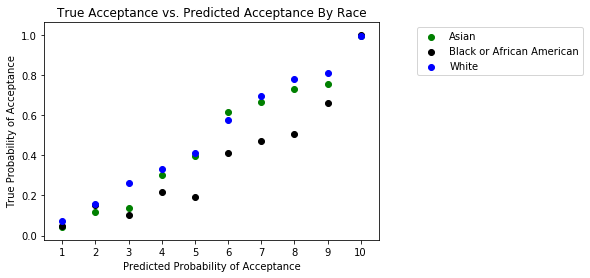

In [40]:
plotTrueVsPredictedApprovalByRace(raceAndProbData)

## After controlling for many factors, Blacks are persistently approved at lower rates

On the x-axis, we use the logistic regression model trained above to generate the probability that a loan applicant in our test set was approved for a loan and then grouped each applicant by the probability decile they were predicted to belong to.  Then, once individuals were grouped into 10 groups, we computed the actual fraction of each group by racial group that was accepted. For example, the points above x = 2 indicate that for Whites who were predicted to have between a 10% and 20% chance of being approved were actual approved about 16% of the time. The difference in approval is clearest for the candidates who have qualities that make them neither a clear approval or a clear rejection.  Whites and Asians who are in Group 6 had just under a 60% true approval rating which is a little higher than we might expect given that this contained everyone who the model predicted would be  approved 50-60% of the time.  However, Blacks who had qualities that put them in Group 6 were in fact only approved 40% of the time.  

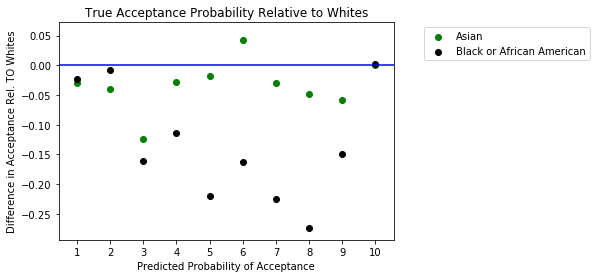

On average, across all probability groups, the average asian apporval rating was -3.35 percentage points
less than the comparable white approval rating.
On average, across all probability groups, the average black apporval rating was -13.34 percentage points
less than the comparable white approval rating.


In [41]:
plotApprovalDifferences(raceAndProbData)

#### Plotting the difference
This plot shows the difference between asian and black approval rates relative to whites in the same group.  If you take the previous plot and subtract the White sereis from the Asian series and the Black series, then the values you get would be this plot. Again at the extreme ends of the distribution, discrimination is virtually nonexistent but for the middle it seem quite likely that race is taken into account when approving loans

# Does including race in the regression eliminate this apparent bias?

#### Rerun the same analysis but include the applicant_race_name_1 as a proxy for race. Data is process in the same way. Only difference is that race is now a variable in the logistic regression

In [42]:
logisticWithRaceFilename = 'logisticDataWithRace.pickle'
logisticDataWithRaceExists = os.path.isfile(logisticWithRaceFilename)
if logisticDataWithRaceExists:
    with open(logisticWithRaceFilename, 'rb') as f:
        logisticDataWithRace = pickle.load(f)
else:
    logisticDataWithRace = df_test[df_test.applicant_race_name_1.isin([Race.Asian, Race.Black, Race.White])]\
                   [["action_taken_name", "applicant_race_name_1"] + continuousVars + discreteVars].copy()
    n0 = len(logisticDataWithRace)
    # Drop entries with na's which must be float("nan")
    logisticDataWithRace = logisticDataWithRace.dropna()
    # drop entries that have the string "nan" as a result of pre-processing conversion to csv
    # we filter out Race.nan's above
    for var in set(discreteVars) - set(['income_bracket']):
        logisticDataWithRace = logisticDataWithRace[logisticDataWithRace[var] != 'nan']
    n1 = len(logisticDataWithRace)
    print("Start: %d\tComplete: %d\tDropped: %d (%.2f%%)" % (n0, n1, n0 - n1, 100 * (n0 - n1) / float(n0)))

    # # Z-Score Continuous Variables
    for var in continuousVars:
        logisticDataWithRace[[var]] = ((logisticDataWithRace[[var]] - logisticDataWithRace[[var]].mean()) 
        /  logisticDataWithRace[[var]].std())

    # Add Dummy Variables for Discrete Variables
    addDummiesFor = sorted(list(discreteVars) + ["applicant_race_name_1"])
    for var in addDummiesFor:
        sys.stdout.write("Starting: "); sys.stdout.write(var); sys.stdout.write("\t")
        u = sorted(logisticDataWithRace[var].unique())
        r = logisticDataWithRace.apply(lambda x: oneHotFromCategory(x[var], u), axis = 1)
        out = np.array([i for i in r.values])
        logisticDataWithRace = logisticDataWithRace.join(pd.DataFrame(out, columns = u, 
                                                                      index = logisticDataWithRace.index))
        sys.stdout.write("Finished: "); sys.stdout.write(var); sys.stdout.write("\n")

    with open(logisticWithRaceFilename, 'wb') as f:
        pickle.dump(logisticDataWithRace, f, pickle.HIGHEST_PROTOCOL)


logisticDataWithRace = logisticDataWithRace.rename(logisticDataColNames, axis = 1)
logisticDataWithRace = logisticDataWithRace.rename({Race.Asian : "Asian", Race.Black: "Black", 
                                                    Race.White: "White"}, axis = 1)

In [43]:
np.random.seed(4321) # use the same seed to ensure we get the same training data every time
trainDataRace, testDataRace = train_test_split(logisticDataWithRace, test_size=0.2)

X_train_race = trainDataRace.drop(discreteVars + ["action_taken_name", "applicant_race_name_1"] , axis = 1)
y_train_binary_race = trainDataRace.action_taken_name

X_test_race = testDataRace.drop(discreteVars + ["action_taken_name", "applicant_race_name_1"] , axis = 1)
y_test_binary_race = testDataRace.action_taken_name

In [44]:
binary_model_with_race = Logit(solver = "lbfgs", max_iter = 1000)
binary_model_with_race.fit(X_train_race.values, y_train_binary_race.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
raceAndProbDataRaceIncluded = createRaceAndProbData(df_test, binary_model_with_race, X_test_race)

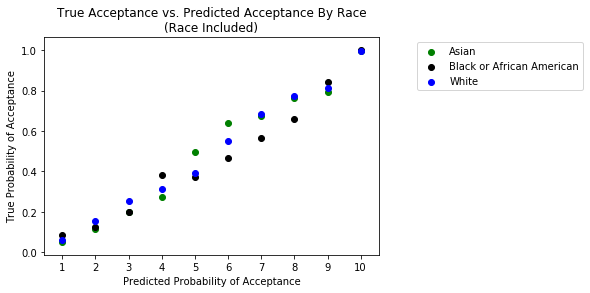

In [46]:
plotTrueVsPredictedApprovalByRace(raceAndProbDataRaceIncluded, raceIncluded = True)

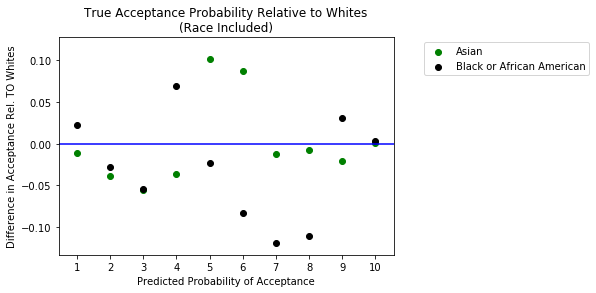

On average, across all probability groups, the average asian apporval rating was 0.08 percentage points
more than the comparable white approval rating.
On average, across all probability groups, the average black apporval rating was -2.92 percentage points
less than the comparable white approval rating.


In [47]:
plotApprovalDifferences(raceAndProbDataRaceIncluded, raceIncluded = True)

Because the absolute size of the maximum difference has decreased from about 0.2 to about 0.1 and the fact that the differences are much more balanced than before, we can likely conclude that the differences seen after including race are due to other variables captured in the data set or just noise.  Additionally, the fact that including race has reduced the difference between black and white approval rates from approximately 13% to 3% suggests that race plays a role in the loan approval process, though there may some other marginal factors that influence the decision making process that are not observed.   

# Controlling for race does eliminate differential approval ratings
### Evidence that there is discrimination

What these two plots show is that by including race in our model, we no longer see any sort of systematic bias against each racial group.  This is evidence that there is not some other confounding factor that we have accounted for, or at least this shows that if there is some confounding, unobserved variable that could explain the difference seen above in approval rating it is highly correlated with race.  

In [48]:
modelValuesWithRace = pd.DataFrame(np.array([X_test_race.columns.values, binary_model_with_race.coef_[0]]).T, 
             columns = ["parameterName", "coef"])

print(modelValuesWithRace[modelValuesWithRace.parameterName.isin(["Asian", "Black", "White"])])

   parameterName       coef
12         Asian  0.0482175
13         Black  -0.440109
14         White   0.292193


The fact that blacks face lower approval ratings is clearly reflected in these coefficients because the coefficient on the model parameters the corresponds to whether a loan applicant is black has a negative coefficient, while a white applicant has a positive coefficient.  Being Asian does not significantly improve or hurt one's chances at being approved according to this model's coefficients, in fact there is a weakly positive association between being Asian and being approved, though it is not as strong as the relationship for Whites. 

### Confusion Matrix

In [49]:
def getConfusionMatrix(raceAndProbData, racesToInclude = list(raceAndProbData.applicant_race_name_1.unique())):
    actual_pos = (raceAndProbData.action_taken_name == 1.0); actual_neg = (raceAndProbData.action_taken_name == 0.0);
    pred_pos = (raceAndProbData.predictedOutcome == 1.0); pred_neg = (raceAndProbData.predictedOutcome == 0.0);
    
    racialFilter = raceAndProbData.applicant_race_name_1.isin(racesToInclude)

    true_positives = len(raceAndProbData[actual_pos & pred_pos & racialFilter])
    true_negatives = len(raceAndProbData[actual_neg & pred_neg & racialFilter])
    false_positives = len(raceAndProbData[actual_neg & pred_pos & racialFilter])
    false_negatives = len(raceAndProbData[actual_pos & pred_neg & racialFilter])

    TPR = true_positives / (true_positives + false_negatives)
    FPR = false_positives / (true_negatives + false_positives) # 1 - TNR
    TNR = true_negatives / (true_negatives + false_positives)
    FNR = false_negatives / (true_positives + false_negatives) # 1 - TPR

    print("""
            Act.Pos | Act.Neg 
          #-------------------#
          |         |         |
    Pred. |  (TPR)  |  (FPR)  |
    Pos   |  %0.3f  |  %0.3f  | 
          |         |         |
    ------|---------#---------|
          |         |         |
    Pred. |  (FNR)  |  (TNR)  |
    Neg   |  %0.3f  |  %0.3f  |
          |         |         |
          #-------------------#
    """ % (TPR, FPR, FNR, TNR))

In [50]:
getConfusionMatrix(raceAndProbData)


            Act.Pos | Act.Neg 
          #-------------------#
          |         |         |
    Pred. |  (TPR)  |  (FPR)  |
    Pos   |  0.926  |  0.330  | 
          |         |         |
    ------|---------#---------|
          |         |         |
    Pred. |  (FNR)  |  (TNR)  |
    Neg   |  0.074  |  0.670  |
          |         |         |
          #-------------------#
    


In [51]:
getConfusionMatrix(raceAndProbData, [Race.Asian])


            Act.Pos | Act.Neg 
          #-------------------#
          |         |         |
    Pred. |  (TPR)  |  (FPR)  |
    Pos   |  0.933  |  0.349  | 
          |         |         |
    ------|---------#---------|
          |         |         |
    Pred. |  (FNR)  |  (TNR)  |
    Neg   |  0.067  |  0.651  |
          |         |         |
          #-------------------#
    


In [52]:
getConfusionMatrix(raceAndProbData, [Race.Black])


            Act.Pos | Act.Neg 
          #-------------------#
          |         |         |
    Pred. |  (TPR)  |  (FPR)  |
    Pos   |  0.906  |  0.189  | 
          |         |         |
    ------|---------#---------|
          |         |         |
    Pred. |  (FNR)  |  (TNR)  |
    Neg   |  0.094  |  0.811  |
          |         |         |
          #-------------------#
    


In [53]:
getConfusionMatrix(raceAndProbData, [Race.White])


            Act.Pos | Act.Neg 
          #-------------------#
          |         |         |
    Pred. |  (TPR)  |  (FPR)  |
    Pos   |  0.926  |  0.350  | 
          |         |         |
    ------|---------#---------|
          |         |         |
    Pred. |  (FNR)  |  (TNR)  |
    Neg   |  0.074  |  0.650  |
          |         |         |
          #-------------------#
    


### Confusion Matrix Analysis

Our classifier treats Whites and Asians virtually identically from a confusion matrix perspective. However, our classifier is less likely to "mistakenly" approve a black applicant for a loan (the False Positive Rate for Blacks is 19%, compared to 35% for whites) and more likely to "mistakenly" reject a black applicant for a loan (the False Negative Rate for Blacks is 9.4%, compared to 7.4% for Whites). These discrepancies are most prevalent in the ~50% probability of loan origination/purchased by an institution range. The story behind these results may be that in cases in which it is unclear as to whether a loan applicant should be approved (when the model says they have a 50% probability of approval), loan officers consciously or not give the benefit of the doubt to White and Asian applicants but not to black applicants.  For applicants who have characteristics that the model views as being nearly automatic qualifiers or disqualifiers for a loan, loan officers either definitively know what to do in these cases or, more cynically, do not have any room to discriminate against different applicants because such an action could clearly be perceived as discriminatory.